In [ ]:
import os
from pathlib import Path
from gurobipy import Model, GRB
from data_loader import load_prices, load_storage, load_efficiency, load_plant_capacity, load_demand
import pandas as pd

# Data Loading from data folder in the parent directory
current_dir = Path().resolve()
data_folder = os.path.join(current_dir.parent, "data")
fuel_prices_file = os.path.join(data_folder, "fuel_prices.csv")           # Price in EUR/tonne (coal,oil) or EUR/m3 (gas)
storage_file = os.path.join(data_folder, "storage.csv")         # Max storage in tonnes/m3
efficiency_file = os.path.join(data_folder, "efficiency.csv")   # efficiency of MWh th to MWh el
plant_file = os.path.join(data_folder, "plant_capacity.csv")    # Plant capacity in MWh/month
demand_file = os.path.join(data_folder, "electricity_demand.csv")           # Monthly demand in MWh

start_date = "2020-01-01"
end_date = "2020-12-31"

fuels = ["coal", "oil", "gas"]
zone = 'DK_2'

try:
    fuel_prices_df = load_prices(fuel_prices_file, start_date, end_date)
    storage = load_storage(storage_file)
    efficiency = load_efficiency(efficiency_file)
    plant_capacity = load_plant_capacity(plant_file)
    demand_df = load_demand(demand_file, start_date, end_date, zone=zone ,supply_factor=0.0005)
except Exception as e:
    raise RuntimeError(f"Error loading data: {e}")


# Forloop over each timestep and saving results in df results
results = pd.DataFrame(columns=['Month', 'Cost_EUR','Accumulated_Cost' , 'Coal_Bought', 'Oil_Bought', 'Gas_Bought',
                                   'Coal_Generated', 'Oil_Generated', 'Gas_Generated'])

for t in range(len(demand_df)):
    print(f"Time step: {t}, Date: {demand_df.index[t]}")
    
    # Model Initialization
    m = Model("Fuel_Procurement_OneMonth")

    # Decision Variables
    x = {fuel: m.addVar(lb=0, ub=storage[fuel], name=f"buy_{fuel}") for fuel in fuel_prices_df.columns if fuel in fuels}
    y = {fuel: m.addVar(lb=0, ub=plant_capacity[fuel], name=f"gen_{fuel}") for fuel in fuel_prices_df.columns if fuel in fuels}

    m.update()

    # Constraints
    m.addConstr(sum(y[fuel] for fuel in y) >= demand_df.iloc[t][zone], "Demand_Constraint")
    for fuel in y:
        m.addConstr(y[fuel] <= efficiency[fuel] * x[fuel], f"efficiency_Constraint_{fuel}")
        # Print the added constraint for verification
        print(f"Added constraint: gen_{fuel} <= {efficiency[fuel]} * buy_{fuel}")
    m.update()

    # Objective
    m.setObjective(sum(fuel_prices_df.iloc[t][fuel] * x[fuel] for fuel in x),GRB.MINIMIZE) 
    m.update()

    # Optimize
    m.optimize()

    # print results
    if m.status == GRB.OPTIMAL:
        total_cost = m.objVal
        print(f"Total Cost: EUR {total_cost}")
    else:
        print("No optimal solution found for time step:", t)
        # Exit the loop if no optimal solution is found
        break
    # Store results
    results = pd.concat([results, pd.DataFrame([{
        'Month': demand_df.index[t],
        'Cost_EUR': total_cost,
        'Accumulated_Cost': results['Cost_EUR'].sum() + total_cost,
        'Coal_Bought': x['coal'].X if 'coal' in x else 0,
        'Oil_Bought': x['oil'].X if 'oil' in x else 0,
        'Gas_Bought': x['gas'].X if 'gas' in x else 0,
        'Coal_Generated': y['coal'].X if 'coal' in y else 0,
        'Oil_Generated': y['oil'].X if 'oil' in y else 0,
        'Gas_Generated': y['gas'].X if 'gas' in y else 0
    }])], ignore_index=True)



# Print running cost for each month
print(results)

# Summarize Yearly Cost
total_yearly_cost = results['Accumulated_Cost'].iloc[-1]
print(f"Total Yearly Cost: EUR {total_yearly_cost}")

Time step: 0, Date: 2020-01-31 00:00:00
Set parameter Username
Set parameter LicenseID to value 2728218
Academic license - for non-commercial use only - expires 2026-10-27
Added constraint: gen_coal <= 0.38 * buy_coal
Added constraint: gen_oil <= 0.33 * buy_oil
Added constraint: gen_gas <= 0.55 * buy_gas
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4 rows, 6 columns and 9 nonzeros
Model fingerprint: 0xd13d7655
Coefficient statistics:
  Matrix range     [3e-01, 1e+00]
  Objective range  [6e+00, 5e+01]
  Bounds range     [4e+02, 5e+03]
  RHS range        [1e+03, 1e+03]
Presolve removed 3 rows and 3 columns
Presolve time: 0.00s
Presolved: 1 rows, 3 columns, 3 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00

C:\Users\bjsb\AppData\Local\Temp\ipykernel_25092\2267003335.py:72: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{



Added constraint: gen_coal <= 0.38 * buy_coal
Added constraint: gen_oil <= 0.33 * buy_oil
Added constraint: gen_gas <= 0.55 * buy_gas
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4 rows, 6 columns and 9 nonzeros
Model fingerprint: 0x947791de
Coefficient statistics:
  Matrix range     [3e-01, 1e+00]
  Objective range  [6e+00, 3e+01]
  Bounds range     [4e+02, 5e+03]
  RHS range        [9e+02, 9e+02]
Presolve removed 3 rows and 3 columns
Presolve time: 0.01s
Presolved: 1 rows, 3 columns, 3 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.153129e+02   0.000000e+00      0s
       1    1.6825279e+04   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal o

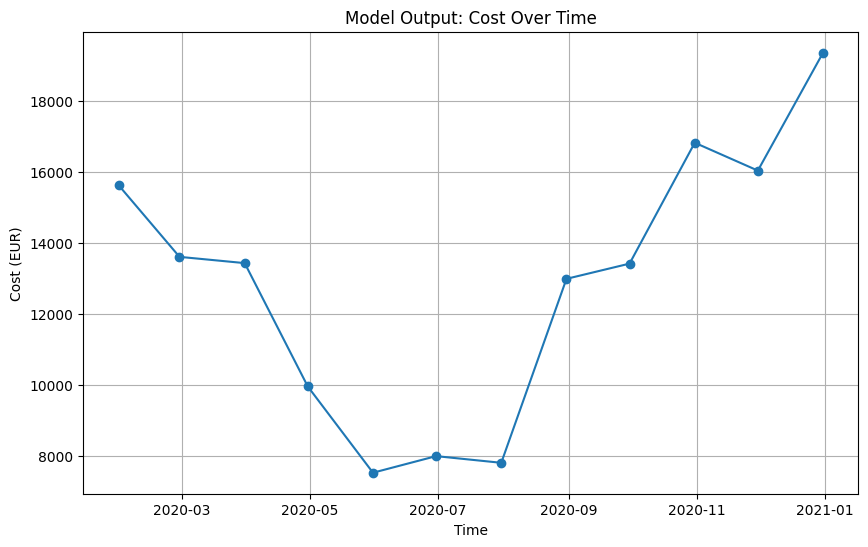

In [2]:
# plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(demand_df.index, results['Cost_EUR'], marker='o')
plt.title('Model Output: Cost Over Time')
plt.xlabel('Time')
plt.ylabel('Cost (EUR)')
plt.grid()
plt.show()


In [3]:
# save results to a csv file

results_dir = os.path.join(current_dir.parent, "results/model1")
os.makedirs(results_dir, exist_ok=True)
results.to_csv(os.path.join(results_dir, 'running_cost_results.csv'), index=False)

